In [ ]:
array = [1,3,4,5,29,8,51]
def firstAndSecondMaxIndex(array):
    if len(array) < 2:
        return 0,-1
    max1 = max(array)
    max1Index = array.index(max1)
    #array.pop(max1Index)
    array[max1Index] = 0
    max2 = max(array)
    max2Index = array.index(max2)
    array[max1Index] = max1
    return max1Index, max2Index
print(firstAndSecondMaxIndex(array))
print(array)

In [ ]:
d = 2
if (d != 2 and d!= 3):
    print ("not 2 or 3")
else:
    print("is 2 or 3")

In [ ]:
dictionary = {}
print("gg" in dictionary)
if "gg" not in dictionary:
    dictionary["gg"] = "value"
else:
    print(dictionary["gg"])

In [ ]:
a = [1,2,3,4,5,6,7,8,9,10]
print(a[5:16])
print(a[3:5])

In [ ]:
CAM_TRACKER = {}

target_cam = 0
counter = 0
def tracker_cam(target_cam,xyxy = (100,200)):
    global counter
    closed = -1
    if target_cam in CAM_TRACKER:
        for tid,data in CAM_TRACKER[target_cam].items():
            if(data["tracking_xyxy"][0] == xyxy[0]):
                data["tracking_xyxy"] = xyxy
                closed = tid
    else: 
        CAM_TRACKER[target_cam] = {}
    if closed == -1:
        counter += 1
        track_info = {
               "tracking_xyxy" : xyxy,
               "tracking_missed_frame" : 1}
        print(counter)
        CAM_TRACKER[target_cam][counter] = track_info
    
tracker_cam(0,(100,200))
tracker_cam(0,(150,200))
tracker_cam(1,(100,200))
tracker_cam(1,(200,300))

for cam_id, tracks in CAM_TRACKER.items():
    print(f"Camera {cam_id}:")
    for tid, data in tracks.items():
        print(f"  Tracking ID: {tid}, XYXY: {data['tracking_xyxy']}, Missed Frames: {data['tracking_missed_frame']}")

In [ ]:
dict_a = {}
dict_b = {'a': 1, 'b': 2}
#dict_a.update(dict_b)
b = '1'
dict_a[b] = dict_b
print(dict_a['1'])

In [ ]:
def get_points(image_path):
    points = []
    def click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print(f"Point: ({x}, {y})")
    img = cv2.imread(image_path)
    cv2.imshow("Pick Points", img)
    cv2.setMouseCallback("Pick Points", click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return points

points = get_points(r"C:\Users\choni\Pictures\5-51.png")

In [ ]:
import cv2
import numpy as np

# pts_cam1: manually picked points in image from camera 1
# pts_cam2: corresponding points in image from camera 2

#pts_cam2 = np.array([[1253, 0], [1292, 540], [1235, 1051], [574, 1051], [506, 590], [547, 1]], dtype=np.float32)
pts_cam1 = np.array([[1223, 1], [1282, 572], [1247, 1055], [552, 1055], [497, 616], [558, 1]], dtype=np.float32)
pts_cam2 = np.array([[1253, 0], [1292, 540], [1235, 1051], [574, 1051], [506, 590], [547, 1]], dtype=np.float32)

H, _ = cv2.findHomography(pts_cam2, pts_cam1)  # maps cam2 to cam1 view

# To warp cam2 image to cam1 perspective:
img2 = cv2.imread(r"C:\Users\choni\Pictures\5-51.png")
img2_warped = cv2.warpPerspective(img2, H, (width, height))


In [40]:
import cv2
import numpy as np
import json
import os

def get_points(img_path, win_name):
    points = []

    def click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print(f"{win_name}: ({x}, {y})")

    img = cv2.imread(img_path)
    copy = img.copy()
    cv2.namedWindow(win_name)
    cv2.setMouseCallback(win_name, click)

    print(f"[INFO] Click matching points in {win_name}. ESC to finish.")
    while True:
        for pt in points:
            cv2.circle(img, pt, 4, (0, 255, 0), -1)
        cv2.imshow(win_name, img)
        if cv2.waitKey(1) == 27:
            break
        img = copy.copy()

    cv2.destroyAllWindows()
    return np.array(points, dtype=np.float32)

def load_or_get_points(img1, img2, file_path, overwrite=False):
    if overwrite or not os.path.exists(file_path):
        pts1 = get_points(img1, f"Points in {img1}")
        pts2 = get_points(img2, f"Points in {img2}")
        with open(file_path, 'w') as f:
            json.dump({'pts1': pts1.tolist(), 'pts2': pts2.tolist()}, f)
    else:
        with open(file_path, 'r') as f:
            data = json.load(f)
            pts1 = np.array(data['pts1'], dtype=np.float32)
            pts2 = np.array(data['pts2'], dtype=np.float32)
    return pts1, pts2

def compute_pairwise_homographies(cam_paths, overwrite=False):
    H_list = []

    for i in range(len(cam_paths) - 1):
        pts_ref, pts_cur = load_or_get_points(cam_paths[i], cam_paths[i+1], f"pts_{i}_{i+1}.json", overwrite)
        H, _ = cv2.findHomography(pts_cur, pts_ref)  # maps current to reference
        H_list.append(H)
        print(f"[INFO] Computed H_{i+1}{i}:\n{H}\n")

    return H_list

def chain_homographies(H_list):
    H21, H32, H43 = H_list
    H31 = H21 @ H32
    H41 = H21 @ H32 @ H43
    return [np.eye(3), H21, H31, H41]  # H_11 is identity

def warp_images(cam_paths, H_to_cam1):
    base_img = cv2.imread(cam_paths[0])
    h, w = base_img.shape[:2]
    warped_imgs = []

    for i in range(4):
        img = cv2.imread(cam_paths[i])
        warped = cv2.warpPerspective(img, H_to_cam1[i], (w, h))
        warped_imgs.append(warped)

    return warped_imgs

def visualize_overlap(warped_imgs):
    # Use max blend for visibility
    stacked = np.zeros_like(warped_imgs[0])
    for img in warped_imgs:
        mask = (img > 0)
        stacked[mask] = img[mask]
    cv2.imshow("All cameras aligned to Cam1", stacked)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# === Main ===
if __name__ == "__main__":
    cam_paths = [
        r"C:\Users\choni\Pictures\554-sync(0001AM 21 April 2025).png",
        r"C:\Users\choni\Pictures\553-sync(0001AM 21 April 2025).png",
        r"C:\Users\choni\Pictures\552-sync(0001AM 21 April 2025).png",
        r"C:\Users\choni\Pictures\551-sync(0001AM 21 April 2025).png"
    ]

    # Step 1: Compute homographies between pairs
    H_pairwise = compute_pairwise_homographies(cam_paths, overwrite=True)

    # Step 2: Chain transformations to map everything to Cam1
    H_to_cam1 = chain_homographies(H_pairwise)

    # Step 3: Warp each image into Cam1’s space
    warped_imgs = warp_images(cam_paths, H_to_cam1)

    # Step 4: Visualize overlap
    visualize_overlap(warped_imgs)


[INFO] Click matching points in Points in C:\Users\choni\Pictures\554-sync(0001AM 21 April 2025).png. ESC to finish.
Points in C:\Users\choni\Pictures\554-sync(0001AM 21 April 2025).png: (1529, 1065)
Points in C:\Users\choni\Pictures\554-sync(0001AM 21 April 2025).png: (1490, 1051)
Points in C:\Users\choni\Pictures\554-sync(0001AM 21 April 2025).png: (324, 1080)
Points in C:\Users\choni\Pictures\554-sync(0001AM 21 April 2025).png: (289, 1062)
[INFO] Click matching points in Points in C:\Users\choni\Pictures\553-sync(0001AM 21 April 2025).png. ESC to finish.
Points in C:\Users\choni\Pictures\553-sync(0001AM 21 April 2025).png: (1498, 43)
Points in C:\Users\choni\Pictures\553-sync(0001AM 21 April 2025).png: (1546, 73)
Points in C:\Users\choni\Pictures\553-sync(0001AM 21 April 2025).png: (279, 24)
Points in C:\Users\choni\Pictures\553-sync(0001AM 21 April 2025).png: (241, 4)
[INFO] Computed H_10:
[[-1.76062981e+00  4.28218923e+00  5.91036205e+02]
 [-1.66721163e+00  3.15257123e+00  1.06480

In [34]:
import cv2
import numpy as np
import json
import os

# === Undistortion ===
def undistort_image(img, K, D):
    h, w = img.shape[:2]
    new_K, _ = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1)
    return cv2.undistort(img, K, D, None, new_K)

# === Point Selection ===
def get_points(image_path, window_name="Pick Points"):
    points = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print(f"Point: ({x}, {y})")

    img = cv2.imread(image_path)
    clone = img.copy()
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, click_event)

    print(f"[INFO] Click points in {image_path}. Press ESC to finish.")
    while True:
        for pt in points:
            cv2.circle(img, pt, 4, (0, 255, 0), -1)
        cv2.imshow(window_name, img)
        key = cv2.waitKey(1)
        if key == 27:  # ESC
            break
        img = clone.copy()

    cv2.destroyAllWindows()
    return np.array(points, dtype=np.float32)

# === Save/Load Points ===
def save_points(file_path, points1, points2):
    with open(file_path, 'w') as f:
        json.dump({'points1': points1.tolist(), 'points2': points2.tolist()}, f)

def load_points(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
        return np.array(data['points1'], dtype=np.float32), np.array(data['points2'], dtype=np.float32)

# === Main Workflow ===
def compute_homography_and_warp(img1_path, img2_path, save_points_file="points.json", overwrite=False):
    # Step 1: Load and undistort
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Replace these with your camera's actual calibration data
    fx, fy = 800, 800
    cx, cy = img1.shape[1] // 2, img1.shape[0] // 2
    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]])
    D = np.array([-0.35, 0.2, 0.0, 0.0])  # Adjust for your distortion

    img1 = undistort_image(img1, K, D)
    img2 = undistort_image(img2, K, D)

    # Step 2: Get or load matching points
    if overwrite or not os.path.exists(save_points_file):
        pts1 = get_points(img1_path, "Camera 1")
        pts2 = get_points(img2_path, "Camera 2")
        save_points(save_points_file, pts1, pts2)
    else:
        pts1, pts2 = load_points(save_points_file)

    # Step 3: Compute homography
    H, status = cv2.findHomography(pts2, pts1)

    # Step 4: Warp cam2 into cam1’s perspective
    warped_img2 = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))

    # Step 5: Stack vertically without padding
    #if warped_img2.shape != img1.shape:
    #    warped_img2 = cv2.resize(warped_img2, (img1.shape[1], img1.shape[0]))

    stacked = np.concatenate((img1, warped_img2), axis=0)
    cv2.imwrite("D:\\stacked_img.png", stacked) #save crop
    # Show result
    cv2.imshow("Vertically Stacked: Cam1 (top) + Warped Cam2 (bottom)", stacked)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return H

# === Example usage ===
if __name__ == "__main__":
    cam1_img = r"C:\Users\choni\Pictures\5-52.png"  # top or base camera
    cam2_img = r"C:\Users\choni\Pictures\5-51.png"  # camera to align
    #cam1_img = "cam1.jpg"
    #cam2_img = "cam2.jpg"

    H = compute_homography_and_warp(cam1_img, cam2_img, save_points_file="points.json", overwrite=True)
    print("[INFO] Homography matrix:\n", H)


[INFO] Homography matrix:
 [[ 7.26817537e-01 -2.37140950e+00  2.78348687e+02]
 [-7.31463498e-02 -2.12604251e+00  1.07357404e+03]
 [-5.69183805e-05 -1.57125571e-03  1.00000000e+00]]


In [ ]:
import cv2
import numpy as np
import json
import os

# === Undistortion ===
def undistort_image(img, K, D):
    h, w = img.shape[:2]
    new_K, _ = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1)
    return cv2.undistort(img, K, D, None, new_K)

# === Point Selection ===
def get_points(img_path, window_name):
    points = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print(f"{window_name} point: ({x}, {y})")

    img = cv2.imread(img_path)
    clone = img.copy()
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, click_event)

    print(f"[INFO] Select 4+ matching points in {window_name}. ESC to finish.")
    while True:
        for pt in points:
            cv2.circle(img, pt, 4, (0, 255, 0), -1)
        cv2.imshow(window_name, img)
        key = cv2.waitKey(1)
        if key == 27:
            break
        img = clone.copy()

    cv2.destroyAllWindows()
    return np.array(points, dtype=np.float32)

# === Load or Save Points ===
def load_or_get_points(ref_img_path, target_img_path, save_file, overwrite=False):
    if overwrite or not os.path.exists(save_file):
        pts_ref = get_points(ref_img_path, "Reference Image")
        pts_target = get_points(target_img_path, "Target Image")
        with open(save_file, "w") as f:
            json.dump({"pts_ref": pts_ref.tolist(), "pts_target": pts_target.tolist()}, f)
    else:
        with open(save_file, "r") as f:
            data = json.load(f)
            pts_ref = np.array(data["pts_ref"], dtype=np.float32)
            pts_target = np.array(data["pts_target"], dtype=np.float32)
    return pts_ref, pts_target

# === Warp and Stack ===
def stack_4_images(cam_paths, K, D, overwrite=False):
    # Load and undistort all 4 images
    imgs = [undistort_image(cv2.imread(p), K, D) for p in cam_paths]

    # cam1 is reference, warp cam2, cam3, cam4 to cam1
    warped_imgs = [imgs[0]]  # start with cam1 (topmost)

    for i in range(1, len(imgs)):
        pts1, pts2 = load_or_get_points(cam_paths[0], cam_paths[i], f"points_{i}.json", overwrite)
        H, _ = cv2.findHomography(pts2, pts1)
        warped = cv2.warpPerspective(imgs[i], H, (imgs[0].shape[1], imgs[0].shape[0]))
        warped_imgs.append(warped)

    # Stack vertically (assumes all are same shape)
    stacked = np.vstack(warped_imgs)

    cv2.imshow("4-Camera Vertical Stack", stacked)
    cv2.imwrite("D:\\stacked_img.png", stacked) #save crop
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return stacked

# === Example Usage ===
if __name__ == "__main__":
    # Replace with your actual image paths
    cam_paths = [
        #r"C:\Users\choni\Pictures\5-54.png",  # top camera
        r"C:\Users\choni\Pictures\5-53.png",
        r"C:\Users\choni\Pictures\5-52.png",
        r"C:\Users\choni\Pictures\5-51.png"   # bottom camera
    ]

    # Dummy intrinsics (replace with actual if known)
    fx, fy = 800, 800
    cx, cy = 960, 540  # assume 1920x1080
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    D = np.array([-0.35, 0.2, 0.0, 0.0])  # barrel distortion estimate

    stack_4_images(cam_paths, K, D, overwrite=True)


In [35]:
import shutil
from datetime import datetime, timedelta
import os
import win32netcon
import win32wnet
import csv

current_date = datetime.now()
#hours_list = {}
video_list = []
for i in range(40,41):
#if True:
    #i=4
    yesterday = current_date - timedelta(days=i) 
    print(yesterday)
    
    folder_name = f'{yesterday.year}-{yesterday.month:02}-{yesterday.day:02}'
    folder_name = '2025-04-21'
    cam_names = [
                "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch006_DX-FHD-5-51\\Normal01",
                "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch007_DX-FHD-5-52\\Normal01",
                "DX-NAS-1-03_24-5E-BE-7C-50-AA\\Standard_Format\\Ch005_DX-FHD-5-53\\Normal01",
                "DX-NAS-1-03_24-5E-BE-7C-50-AA\\Standard_Format\\Ch006_DX-FHD-5-54\\Normal01",

                # "DX-NAS-1-03_24-5E-BE-7C-50-AA\\Standard_Format\\Ch001_DX-FHD2-6-01\\Normal01",
                # "DX-NAS-1-03_24-5E-BE-7C-50-AA\\Standard_Format\\Ch002_DX-FHD2-6-02\\Normal01",
                # "DX-NAS-1-03_24-5E-BE-7C-50-AA\\Standard_Format\\Ch003_DX-FHD2-6-03\\Normal01",
                # "DX-NAS-1-03_24-5E-BE-7C-50-AA\\Standard_Format\\Ch004_DX-FHD2-6-04\\Normal01",
                
                
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch001_DX-FHDO-7-03\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch002_DX-FHDO-7-04\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch003_DX-FHDO-7-05\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch004_DX-FHDO-7-06\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch005_DX-FHDO-7-07\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch001_DX-FHD-6-61\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch002_DX-FHD-6-62\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch003_DX-FHD-6-63\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch004_DX-FHD-6-64\\Normal01",
                # "DX-NAS-1-04_24-5E-BE-3D-39-1A\\Standard_Format\\Ch005_DX-FHD-6-65\\Normal01",

                

                ]
    receiver_names = [
        #left
                    "Ch006_DX-FHD-5-51",
                    "Ch007_DX-FHD-5-52",
                    "Ch005_DX-FHD-5-53",
                    "Ch006_DX-FHD-5-54",
        #middle                    
                    # "Ch001_DX_FHD2-6-01",
                    # "Ch002_DX_FHD2-6-02",
                    # "Ch003_DX_FHD2-6-03",
                    # "Ch004_DX_FHD2-6-04",
        # Old right                    
                    #"Ch001_DX_FHDO-7-03",
                    # "Ch002_DX_FHDO-7-04",
                    # "Ch003_DX_FHDO-7-05",
                    # "Ch004_DX_FHDO-7-06",
                    # "Ch005_DX_FHDO-7-07",
        #right                    
                    # "Ch001_DX-FHD-6-61",
                    # "Ch002_DX-FHD-6-62",
                    # "Ch003_DX-FHD-6-63",
                    # "Ch004_DX-FHD-6-64",
                    # "Ch005_DX-FHD-6-65",

                    ]
    cam_path = "\\\\172.16.3.5\\homes\\admin\\DX\\identification_camera"
    receiver_path = "F:\\Nyi Zaw Aung\\815_CowDataChecking\\Sumiyoshii\\Standard_Format\\ALL_Channel_One_Day"
    #cam_list = 
    for camNo in range(len(receiver_names)):
        fromHour = 1
        toHour = 2
        if 'FHDO-7' in cam_names[camNo]:
            fromHour = 9
            toHour = 22
        #video_list = []
        for hour in range(fromHour,toHour):
            #each row for each hour and each column for each file under from path
            #print(f'{cam_names[camNo]} {folder_name} {hour:02
            
            try:
                from_path = f'{cam_path}\\{cam_names[camNo]}\\{folder_name}\\{hour:02}'
                #to_path = f'{receiver_path}\\{receiver_names[camNo]}\\{folder_name}\\{hour:02}'
                #video_list = []
                for video in os.listdir(from_path):
                    if video.endswith('.mp4'):
                        video_list.append(video)
                        break
                #hours_list[hour] = video_list
                #print("x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x")

                #os.system(f'copy "{from_path}" "{to_path}"')
                #copy from_path to_path
            except Exception as aa:
                print("error while copying , ",aa)
       
            
            #\\172.16.3.5\homes\admin\DX\identification_camera\DX-NAS-1-03_24-5E-BE-7C-50-AA\Standard_Format\Ch001_DX-FHD2-6-01\Normal01\2024-11-2\11
            #\\172.16.3.5\homes\admin\DX\identification_camera\DX-NAS-1-03_24-5E-BE-7C-50-AA\Standard_Format\Ch001_DX-FHD2-6-01\Normal01\2024-11-02


2025-05-30 10:46:29.422303


In [ ]:
print(video_list)

In [36]:
def get_max_start_time_per_video(video_list):
    max_start_time = 0
    start_times = []
    print(video_list)
    for video in video_list:
        start_time = int(video.split("-")[1])
        #print(start_time)
        start_times.append(start_time)
        if start_time > max_start_time:
            max_start_time = start_time
    
    #print(start_times)
    #extrack max start time from every start time
    start_times = [max_start_time - x for x in start_times]

    return start_times

In [37]:
print(video_list)
print(get_max_start_time_per_video(video_list))

['20250421-010000-010351.mp4', '20250421-010000-010413.mp4', '20250421-010000-010042.mp4', '20250421-010000-010108.mp4']
['20250421-010000-010351.mp4', '20250421-010000-010413.mp4', '20250421-010000-010042.mp4', '20250421-010000-010108.mp4']
[0, 0, 0, 0]


In [ ]:
print()

In [ ]:
import cv2
import numpy as np

def draw_quarter_circles(image, radius):
    h, w = image.shape[:2]

    # Top-left corner (from corner to center - upper left quarter)
    cv2.ellipse(
        image,
        center=(0, 0),
        axes=(radius, radius),
        angle=0,
        startAngle=0,
        endAngle=90,
        color=(0, 0, 0),
        thickness=-1
    )

    # Top-right corner (upper right quarter)
    cv2.ellipse(
        image,
        center=(w, 0),
        angle=0,
        startAngle=90,
        endAngle=180,
        color=(0, 0, 0),
        thickness=-1
    )

    return image

# Example usage
image = np.ones((300, 400, 3), dtype=np.uint8) * 255  # white background
radius = 100
output = draw_quarter_circles(image, radius)

cv2.imshow('Quarter Circles', output)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [23]:
from collections import defaultdict
my_list = [1, 4, 2, 13, 5, 16, 6, 7, 9, 8, 13, 10, 12, 2, 11, 16] 
value_indices = defaultdict(list)

# Populate the dictionary
for idx, val in enumerate(my_list):
    value_indices[val].append(idx)

# Extract duplicates and their indexes
duplicates = {val: idxs for val, idxs in value_indices.items() if len(idxs) > 1}

print(duplicates)

{2: [2, 13], 13: [3, 10], 16: [5, 15]}


In [ ]:
def combine_boxes(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return [x1, y1, x2, y2]


boxes_to_merge = defaultdict(list)
boxes_to_merge[13] += [[0,0,100,100],'']
boxes_to_merge[13] += [[0,0,200,200],'dd']

boxes_to_merge[2] += [[100,100,150,290],'ee']
boxes_to_merge[2] += [[110,110,170,310],'ee']

#print(boxes_to_merge)

keys = boxes_to_merge.keys()
#print( 2 in keys)

for key,box_to_merge in boxes_to_merge.items():
    print(key,box_to_merge)
    box1 = box_to_merge[0]
    print(box1)
    idx = duplicates[key][0]
    #print(idx  ," for Combined box :" ,combine_boxes(box_to_merge[0],box_to_merge[1]))

13 [[0, 0, 100, 100], 'dd', [0, 0, 200, 200], 'dd']
[0, 0, 100, 100]
2 [[100, 100, 150, 290], 'ee', [110, 110, 170, 310], 'ee']
[100, 100, 150, 290]


In [4]:
a = [1,2,3,4,5,6,7,8,9,10]
print(a[:0])

[]


In [4]:
from datetime import datetime

datetime_str1 = '2025-07-31 13:33:37'
datetime_str2 = '2025-07-31 15:08:20'

# Convert strings to datetime objects
dt1 = datetime.strptime(datetime_str1, '%Y-%m-%d %H:%M:%S')
dt2 = datetime.strptime(datetime_str2, '%Y-%m-%d %H:%M:%S')

# Subtract the two datetime objects
difference = dt2 - dt1

# Print the result
print("Difference:", difference)

Difference: 1:34:43


In [5]:
import os, json, logging, time
#import boto3
#from botocore.config import Config
#from botocore.exceptions import ClientError
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError

log = logging.getLogger()
log.setLevel(logging.INFO)





def http_get(url, headers=None, timeout=10, retries=3, backoff=0.5):
    last_err = None
    for attempt in range(retries):
        try:
            req = Request(url, method="GET", headers=headers or {})
            with urlopen(req, timeout=timeout) as r:
                body = r.read().decode("utf-8")
                return {"ok": True, "status": r.getcode(), "body": body}
        except (HTTPError, URLError) as e:
            last_err = e
            time.sleep(backoff * (2 ** attempt))
        except Exception as e:
            last_err = e
            break
    # failed
    status = getattr(last_err, "code", None)
    msg = getattr(last_err, "reason", None) or str(last_err)
    return {"ok": False, "status": status, "error": msg}

def preview(res):
    if not res.get("ok"):
        return {"ok": False, "status": res.get("status"), "error": str(res.get("error"))[:300]}
    return {"ok": True, "status": res.get("status"), "body_preview": res.get("body", "")[:300]}

def handler():
    release_url = "https://stag-wallet-service.rezerv.co/api/Wallet/release-reserved-credit"

    # Optional headers: from secret.HEADERS then env(API_HEADERS JSON) then env(API_KEY)
    headers = {}
    #if isinstance(secret.get("HEADERS"), dict):
    #    headers.update(secret["HEADERS"])
    #elif os.environ.get("API_HEADERS"):
    #    try:
    #        headers.update(json.loads(os.environ["API_HEADERS"]))
    #    except Exception:
    #        log.warning("API_HEADERS is not valid JSON; ignoring.")
    #elif os.environ.get("API_KEY"):
    #    headers["Authorization"] = f"Bearer {os.environ['API_KEY']}"

    release_res  = http_get(release_url,  headers=headers, timeout=120)

    log.info({"release": preview(release_res)})

    overall_ok  = release_res["ok"]
    status_code = 200 if overall_ok else 502
    return {
        "statusCode": status_code,
        "body": json.dumps({"release": preview(release_res)})
    }
handler()


{'statusCode': 200,
 'body': '{"release": {"ok": true, "status": 200, "body_preview": ""}}'}

In [6]:
from datetime import datetime
start_time = datetime.now()
a = 0
for i in range(1000):
    a += a*i + 2
    for j in range(10):
        b = i * j
time_diff = datetime.now() - start_time 
print(time_diff)
print(time_diff.total_seconds())

0:00:00.001189
0.001189


'C:/Users/choni/Downloads/New folder/origin_td_v2_1.html'

In [13]:
PROJECTILE_TRACKING = {}
PROJECTILE_TRACKING['1']=[{1,2}]


PROJECTILE_TRACKING['1'].append({2,3})
class A:
    def __init__(self, a, b):
        self.a = a
        self.b = b  
print(PROJECTILE_TRACKING)
obj = [A({},2), A({0: [(58.356243120949, 277.3836693642228)]},4)]

a_items = {}
for item in obj:
    a_items.update(item.a)

#a = [{}, {0: [(58.356243120949, 277.3836693642228)]}]
if 0 in a_items:
    print("HAIIII")

{'1': [{1, 2}, {2, 3}]}
HAIIII


In [7]:
import cv2
import numpy as np

def draw_point_on_XY_plane(points):
    
    img = np.ones((500, 500, 3), dtype=np.uint8) * 255  # white background

    for point in points:
        cv2.circle(img, tuple(point), 5, (0, 0, 255), -1)  # red point

    cv2.imshow('Points on XY Plane', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

points = [[142,362] , [197,397], [67,277], [97,319]]
draw_point_on_XY_plane(points)


In [24]:
from math import sin, asin, tan, pi
x = 27
y1 = 60 * sin(0.012 * x - 1.38) + 337
y2 = 0.89 * x  + 227
y3 = y1 - (y1 - y2)/2
y4 = y2 + (y1 - y2)/2
print(y1)
print(y2)
print(y3)
print(y4)

def Calculate_Projectile_Up(y):
    y_up = 60 * sin(0.012 * y - 1.38) + 337
    return y_up
    
def Calculate_Projectile_Down(y):
    y_down = (1.38 + asin((y - 337) / 60)) / 0.012
    return y_down
y5 = Calculate_Projectile_Up(27)
y6 = Calculate_Projectile_Down(337)
print(y5)
print(y6)

284.7764187761427
251.03
267.90320938807133
267.90320938807133
284.7764187761427
114.99999999999999


In [15]:
areas = [1,3,5,2,4]
areas.sort(key=lambda x: x, reverse=True)
print(areas)

[5, 4, 3, 2, 1]


In [36]:
import cv2
import os
import glob

# Base training path
base_path = r"C:\Identification dataset\KNP_identification_dataset\Validation"
output_path = r"C:\Identification dataset\KNP_identification_dataset_gray\Validation"

for sub in os.listdir(base_path):
    if not os.path.isdir(os.path.join(base_path, sub)):
        continue
    input_dir = os.path.join(base_path, sub)
    output_dir = os.path.join(output_path, sub)

    os.makedirs(output_dir, exist_ok=True)

    for img_path in glob.glob(os.path.join(input_dir, "*")):
        # Read the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable file: {img_path}")
            continue

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Make it slightly lighter
        # (alpha > 1 brightens, beta adds constant brightness)
        #lighter = cv2.convertScaleAbs(gray, alpha=1.1, beta=15)

        # Save to output folder with same filename
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, gray)

        #print(f"Saved grayscale image: {save_path}")

print("✅ Conversion completed successfully.")


✅ Conversion completed successfully.


In [18]:
import numpy as np
arr = np.random.randint(0, 255, (5,5))
print("Mean:", np.mean(arr, axis=0))
norm = (arr - arr.min()) / (arr.max() - arr.min())
print("Normalized:\n", norm)

Mean: [141.4 127.  166.6  78.4 189.8]
Normalized:
 [[0.         0.05217391 0.96956522 0.37391304 0.65217391]
 [0.59130435 0.58695652 0.22173913 0.15652174 0.59565217]
 [0.6826087  0.86086957 0.75652174 0.10434783 0.83913043]
 [0.68695652 0.17391304 1.         0.52173913 0.86956522]
 [0.59130435 0.56521739 0.15217391 0.02608696 0.64782609]]


In [21]:
import cv2
img = cv2.imread(r"C:\Users\choni\Pictures\5-51.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 200)
cv2.imshow("Edges", edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

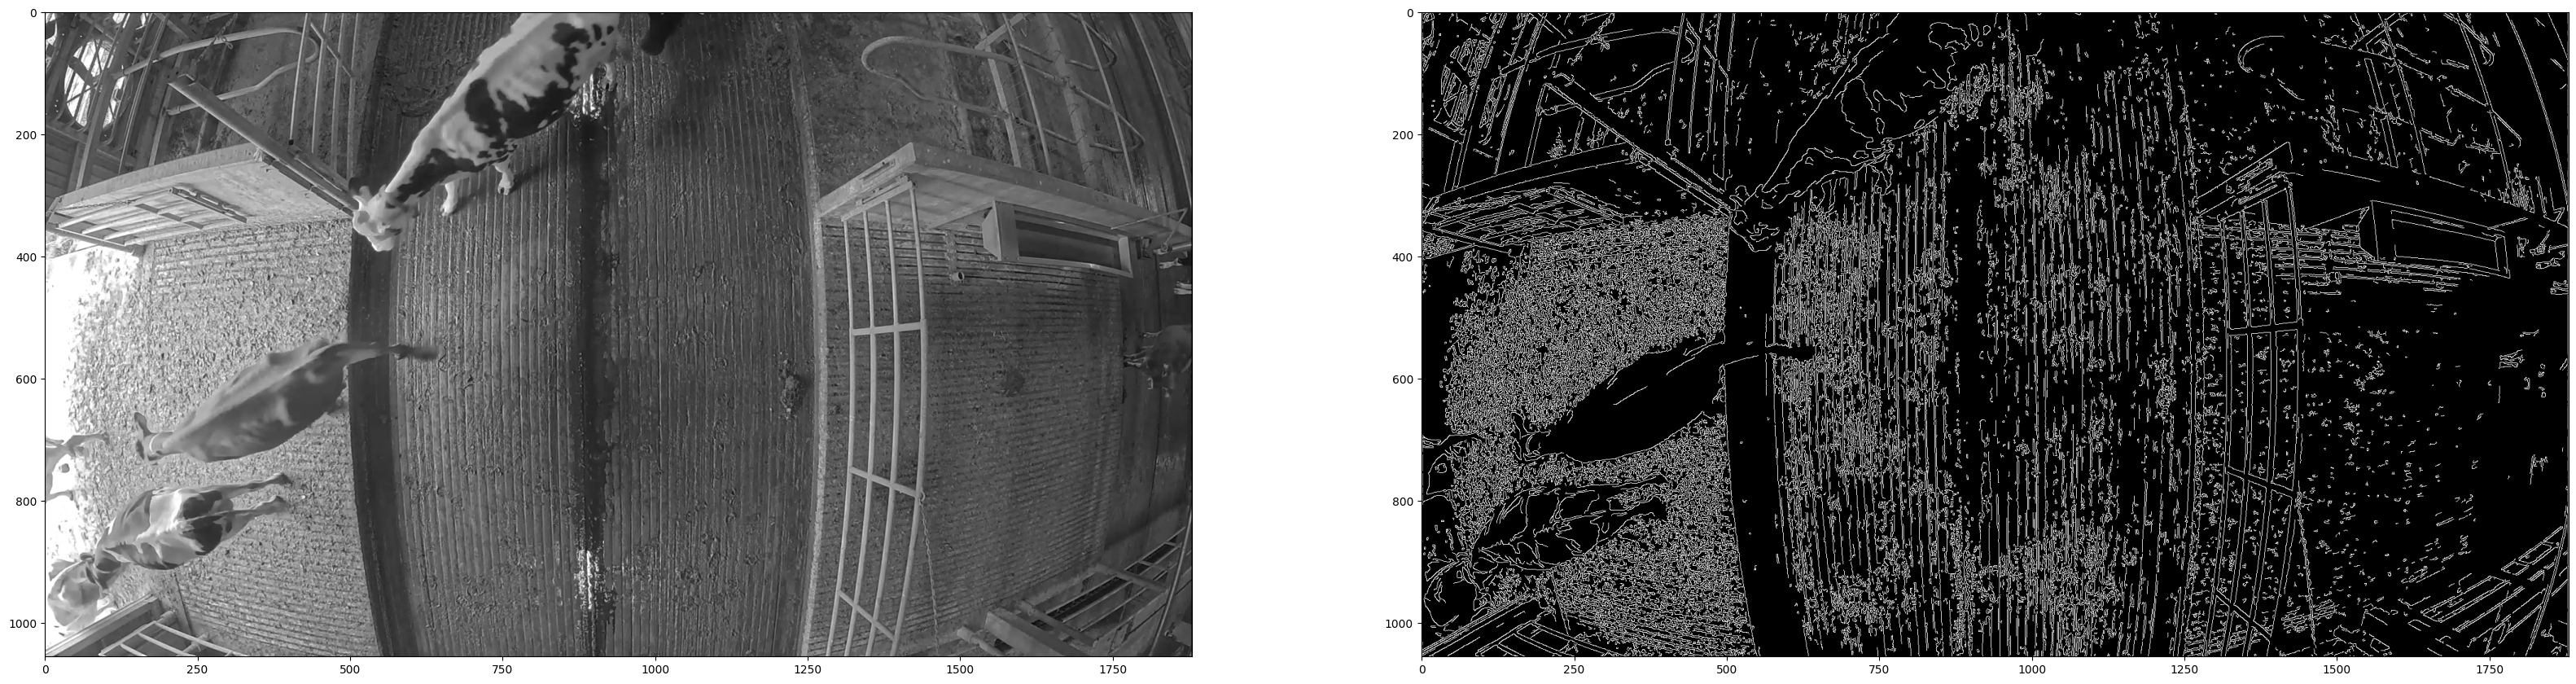

In [34]:
import matplotlib.pyplot as plt
#make bigger plots
plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
plt.imshow(gray, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(edges, cmap = 'gray')
plt.show()



In [ ]:
import os
import csv
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

# ==============================
# Global Variables
# ==============================
annotations = {}  # {image_name: [(left, top, right, bottom), ...]}
current_image = None
current_image_tk = None
image_path = None
boxes = []
selected_box = None
start_x = start_y = None
output_csv = "annotations.csv"

# ==============================
# Helper Functions
# ==============================

def load_annotations():
    """Load existing annotation data from CSV into memory."""
    if not os.path.exists(output_csv):
        return
    with open(output_csv, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            img = row["imagePath"]
            left = int(float(row["left"]))
            top = int(float(row["top"]))
            right = int(float(row["right"]))
            bottom = int(float(row["bottom"]))
            annotations.setdefault(img, []).append((left, top, right, bottom))
    print(f"Loaded {len(annotations)} annotated images from {output_csv}")

def save_annotations():
    """Save all annotations in memory to CSV."""
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["imagePath", "left", "top", "right", "bottom"])
        for img, box_list in annotations.items():
            for (l, t, r, b) in box_list:
                writer.writerow([img, l, t, r, b])
    print(f"✅ All annotations saved to {output_csv}")

def load_image(image_name):
    """Load image into canvas and draw annotations."""
    global current_image, current_image_tk, image_path, boxes, selected_box

    image_path = os.path.join(image_folder, image_name)
    current_image = Image.open(image_path)
    current_image_tk = ImageTk.PhotoImage(current_image)

    canvas.delete("all")
    canvas.create_image(0, 0, anchor=tk.NW, image=current_image_tk)

    boxes = annotations.get(image_name, []).copy()
    selected_box = None

    for box in boxes:
        l, t, r, b = box
        canvas.create_rectangle(l, t, r, b, outline="red", width=2)
    print(f"Loaded {len(boxes)} boxes for {image_name}")

# ==============================
# Mouse Events
# ==============================

def on_mouse_down(event):
    global start_x, start_y
    start_x, start_y = event.x, event.y

def on_mouse_drag(event):
    global start_x, start_y
    if start_x and start_y:
        canvas.delete("temp")
        canvas.create_rectangle(start_x, start_y, event.x, event.y, outline="blue", tag="temp")

def on_mouse_up(event):
    global start_x, start_y
    if start_x and start_y:
        l, t, r, b = sorted([start_x, event.x]), sorted([start_y, event.y])
        new_box = (l[0], t[0], l[1], t[1])
        boxes.append(new_box)
        annotations[os.path.basename(image_path)] = boxes
        canvas.delete("temp")
        draw_boxes()
    start_x = start_y = None

def on_box_select(event):
    global selected_box
    x, y = event.x, event.y
    for i, (l, t, r, b) in enumerate(boxes):
        if l <= x <= r and t <= y <= b:
            selected_box = i
            draw_boxes()
            break

def draw_boxes():
    """Redraw all boxes, highlighting selected one."""
    canvas.delete("all")
    canvas.create_image(0, 0, anchor=tk.NW, image=current_image_tk)
    for i, (l, t, r, b) in enumerate(boxes):
        color = "green" if i == selected_box else "red"
        canvas.create_rectangle(l, t, r, b, outline=color, width=2)

# ==============================
# Keyboard Events
# ==============================

def on_key_press(event):
    global image_path
    if event.char == 's' and image_path:
        save_annotations()
        return

    if selected_box is not None:
        l, t, r, b = boxes[selected_box]
        move = 5
        if event.keysym == 'Up':
            t -= move; b -= move
        elif event.keysym == 'Down':
            t += move; b += move
        elif event.keysym == 'Left':
            l -= move; r -= move
        elif event.keysym == 'Right':
            l += move; r += move
        boxes[selected_box] = (l, t, r, b)
        annotations[os.path.basename(image_path)] = boxes
        draw_boxes()

# ==============================
# GUI Setup
# ==============================

root = tk.Tk()
root.title("Bounding Box Annotator")

# Left Panel: Listbox for images
frame_left = tk.Frame(root)
frame_left.pack(side=tk.LEFT, fill=tk.Y)

scrollbar = tk.Scrollbar(frame_left)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

listbox = tk.Listbox(frame_left, yscrollcommand=scrollbar.set, width=40)
listbox.pack(side=tk.LEFT, fill=tk.Y)
scrollbar.config(command=listbox.yview)

# Right Panel: Canvas for image annotation
canvas = tk.Canvas(root, width=800, height=600, bg="gray")
canvas.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

# ==============================
# Event Bindings
# ==============================
canvas.bind("<Button-1>", on_mouse_down)
canvas.bind("<B1-Motion>", on_mouse_drag)
canvas.bind("<ButtonRelease-1>", on_mouse_up)
canvas.bind("<Button-3>", on_box_select)
root.bind("<Key>", on_key_press)

# ==============================
# Folder Selection and Image Load
# ==============================
image_folder = filedialog.askdirectory(title="Select Image Folder")
if not image_folder:
    print("No folder selected. Exiting.")
    root.destroy()
    exit()

load_annotations()

images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
for img in images:
    listbox.insert(tk.END, img)

def on_image_select(event):
    selection = listbox.curselection()
    if selection:
        index = selection[0]
        image_name = listbox.get(index)
        load_image(image_name)

listbox.bind("<<ListboxSelect>>", on_image_select)

# ==============================
# Run the App
# ==============================
root.mainloop()


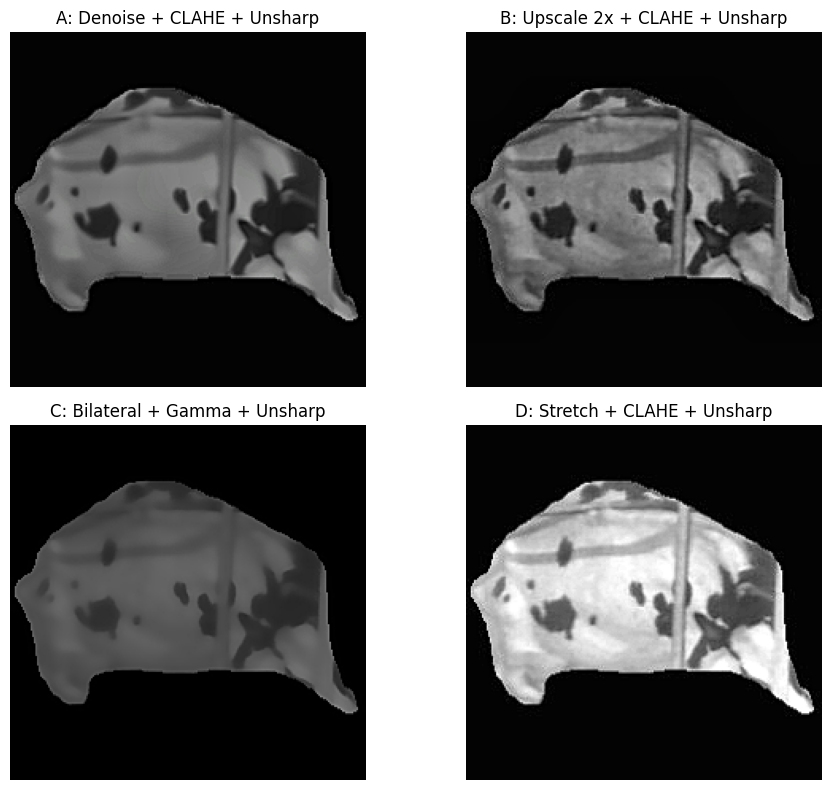

(224,
 224,
 ('E:\\Output\\runs\\KUNNEPPU_identification\\KNP_Merge_and_Batch_identification\\29 Oct Report 2025\\reuse tetris_Sumiyoshi-44\\Base_rtx8000_10_August_2025_20000_v1\\testris_Ch004_Camera 004_E2\\2025-10-11_0023_part 2\\5\\variant_A_denoise_CLAHE_sharp.png',
  'E:\\Output\\runs\\KUNNEPPU_identification\\KNP_Merge_and_Batch_identification\\29 Oct Report 2025\\reuse tetris_Sumiyoshi-44\\Base_rtx8000_10_August_2025_20000_v1\\testris_Ch004_Camera 004_E2\\2025-10-11_0023_part 2\\5\\variant_B_upscale2x_CLAHE_sharp.png',
  'E:\\Output\\runs\\KUNNEPPU_identification\\KNP_Merge_and_Batch_identification\\29 Oct Report 2025\\reuse tetris_Sumiyoshi-44\\Base_rtx8000_10_August_2025_20000_v1\\testris_Ch004_Camera 004_E2\\2025-10-11_0023_part 2\\5\\variant_C_bilateral_gamma_sharp.png',
  'E:\\Output\\runs\\KUNNEPPU_identification\\KNP_Merge_and_Batch_identification\\29 Oct Report 2025\\reuse tetris_Sumiyoshi-44\\Base_rtx8000_10_August_2025_20000_v1\\testris_Ch004_Camera 004_E2\\2025-10-11_

In [8]:
# Let's load the user's IR image and generate a few enhancement variants.
# We'll preserve RGB (since the user said it's not grayscale) and save multiple outputs for comparison.

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

in_path = Path(r"E:\Output\runs\KUNNEPPU_identification\KNP_Merge_and_Batch_identification\29 Oct Report 2025\reuse tetris_Sumiyoshi-44\Base_rtx8000_10_August_2025_20000_v1\testris_Ch004_Camera 004_E2\2025-10-11_0023_part 2\5\572196_4307_Touching_0_area20414.jpg")
img = cv2.imread(str(in_path))  # BGR
if img is None:
    raise FileNotFoundError("Input image not found at /mnt/data/...")

h, w = img.shape[:2]

def unsharp_mask(bgr, radius=1.5, amount=1.2):
    # Gaussian blur then add weighted residual
    blurred = cv2.GaussianBlur(bgr, (0,0), radius)
    sharp = cv2.addWeighted(bgr, 1+amount, blurred, -amount, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)

def apply_clahe_ycrcb(bgr, clip=2.0, tile=8):
    ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))
    y2 = clahe.apply(y)
    out = cv2.cvtColor(cv2.merge([y2, cr, cb]), cv2.COLOR_YCrCb2BGR)
    return out

def contrast_stretch(bgr, low=1, high=99):
    # Percentile-based stretching per-channel
    out = bgr.copy().astype(np.float32)
    for c in range(3):
        p_low = np.percentile(out[:,:,c], low)
        p_high = np.percentile(out[:,:,c], high)
        if p_high - p_low < 1e-3:
            continue
        out[:,:,c] = (out[:,:,c] - p_low) * 255.0 / (p_high - p_low)
        out[:,:,c] = np.clip(out[:,:,c], 0, 255)
    return out.astype(np.uint8)

def gamma_correct(bgr, gamma=1.1):
    inv = 1.0/gamma
    table = (np.linspace(0,1,256)**inv * 255).astype(np.uint8)
    return cv2.LUT(bgr, table)

# Variant A: Denoise (fastNlMeans), CLAHE on Y, then unsharp
a = cv2.fastNlMeansDenoisingColored(img, None, h=5, hColor=5, templateWindowSize=7, searchWindowSize=21)
a = apply_clahe_ycrcb(a, clip=2.0, tile=8)
a = unsharp_mask(a, radius=1.2, amount=0.9)

# Variant B: , CLAHE, then unsharp
b = apply_clahe_ycrcb(img, clip=2.5, tile=8)
b = unsharp_mask(b, radius=1.4, amount=1.0)

# Variant C: Edge-preserving (bilateral), gamma, unsharp
c = cv2.bilateralFilter(img, d=9, sigmaColor=50, sigmaSpace=50)
c = gamma_correct(c, gamma=1.05)
c = unsharp_mask(c, radius=1.0, amount=1.1)

# Variant D: Contrast stretch, CLAHE, slight unsharp
d = contrast_stretch(img, low=1, high=99)
d = apply_clahe_ycrcb(d, clip=1.8, tile=8)
d = unsharp_mask(d, radius=0.9, amount=0.8)

# Save outputs
out_dir = Path(r"E:\Output\runs\KUNNEPPU_identification\KNP_Merge_and_Batch_identification\29 Oct Report 2025\reuse tetris_Sumiyoshi-44\Base_rtx8000_10_August_2025_20000_v1\testris_Ch004_Camera 004_E2\2025-10-11_0023_part 2\5")
out_dir.mkdir(exist_ok=True)
cv2.imwrite(str(out_dir/"9999999_variant_A_denoise_CLAHE_sharp.png"), a)
cv2.imwrite(str(out_dir/"9999999_variant_B_upscale2x_CLAHE_sharp.png"), b)
cv2.imwrite(str(out_dir/"9999999_variant_C_bilateral_gamma_sharp.png"), c)
cv2.imwrite(str(out_dir/"9999999_variant_D_contraststretch_CLAHE_sharp.png"), d)

# Show a comparison panel (downscale large images for the grid)
def to_rgb(arr_bgr):
    return cv2.cvtColor(arr_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(to_rgb(a)); plt.title("A: Denoise + CLAHE + Unsharp"); plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(to_rgb(b)); plt.title("B: Upscale 2x + CLAHE + Unsharp"); plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(to_rgb(c)); plt.title("C: Bilateral + Gamma + Unsharp"); plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(to_rgb(d)); plt.title("D: Stretch + CLAHE + Unsharp"); plt.axis('off')

plt.tight_layout()
plt.show()

(h, w, (str(out_dir/"variant_A_denoise_CLAHE_sharp.png"),
        str(out_dir/"variant_B_upscale2x_CLAHE_sharp.png"),
        str(out_dir/"variant_C_bilateral_gamma_sharp.png"),
        str(out_dir/"variant_D_contraststretch_CLAHE_sharp.png")))


ReLU Test Accuracy: 0.977
Sigmoid Test Accuracy: 0.883


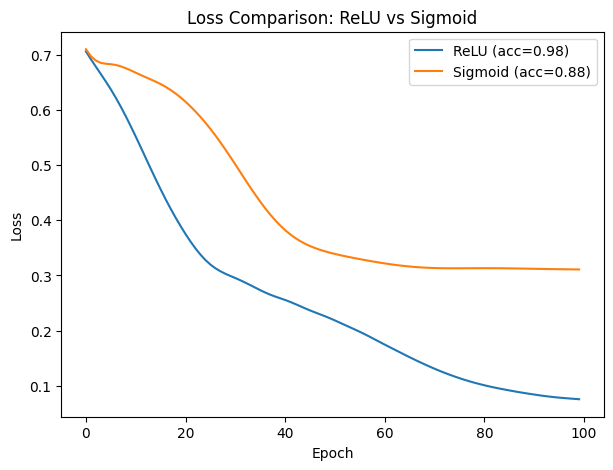

In [1]:
# compare_relu_sigmoid.py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ======= 1. Prepare dataset =======
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# ======= 2. Define model template =======
class SimpleNN(nn.Module):
    def __init__(self, activation):
        super().__init__()
        if activation == "relu":
            act = nn.ReLU()
        elif activation == "sigmoid":
            act = nn.Sigmoid()
        else:
            raise ValueError("activation must be 'relu' or 'sigmoid'")

        self.net = nn.Sequential(
            nn.Linear(2, 16),
            act,
            nn.Linear(16, 8),
            act,
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.net(x)

# ======= 3. Training function =======
def train_model(model, name, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # Evaluate
    with torch.no_grad():
        pred = model(X_test).argmax(1)
        acc = (pred == y_test).float().mean().item()
    print(f"{name} Test Accuracy: {acc:.3f}")
    return losses, acc

# ======= 4. Run both =======
relu_model = SimpleNN("relu")
sigmoid_model = SimpleNN("sigmoid")

relu_losses, relu_acc = train_model(relu_model, "ReLU")
sigmoid_losses, sigmoid_acc = train_model(sigmoid_model, "Sigmoid")

# ======= 5. Plot =======
plt.figure(figsize=(7,5))
plt.plot(relu_losses, label=f"ReLU (acc={relu_acc:.2f})")
plt.plot(sigmoid_losses, label=f"Sigmoid (acc={sigmoid_acc:.2f})")
plt.title("Loss Comparison: ReLU vs Sigmoid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
